# **ИТОГОВЫЙ ПРОЕКТ (выгрузка данных с API, логирование и загрузка в PostgreSQL)**

## INTRO

Задача проекта - подготовить скрипт для загрузки данных с сайта [статистика решения задач на платформе IT-resume](https://b2b.itresume.ru/api/statistics) по API, выгрузки данных в локальную базу PostgreSQL и логированию процесса загрузки/выгрузки.

Интеграция с обучающей платформой (**LIS** система) реализована с применением стандарта **LTI** (**Learning Tools Interoperability**). **LIS** (**Learning Information System**) система - система управления данными студентов.


Логи выгрузки:

*   начало загрузки
*   ошибка доступа
*   преобразование строки
*   завершение загрузки

Также в проекте реализована выгрузка ежедневной статистики решения задач в гугл-таблицу по API и отправка письма с ежедневной статистикой на почту.

Приватные данные (доступ к API, базе postgreSQL, гугл-таблице и почте) вынесены в отдельный модуль Password. В целях безопасности данный модуль к скрипту не прилагается, кроме того, база postgreSQL расположена на локальном сервере. В силу этих причин выполнить скрипт не получится, но в проекте представлены все итоговые таблицы.


## Скрипт загрузки с LIS, выгрузки в PostgreSQL, логирования, заполения гугл-таблицы и отправки письма с гугл-таблицей


In [1]:
pip install gspread oauth2client

In [2]:
import requests # для запроса с API
from datetime import datetime, timedelta # для преобразования в формат дата/время
import json # для преобазования json-строки
import ast
import logging # для логирования
import os  # для создания каталога логирования
import psycopg2 # для загрузки данных в PostgreSQL
from collections import Counter # для расчета статистики по самому популярному часу решения задач
import gspread
from oauth2client.service_account import ServiceAccountCredentials # библиотеки для подключения к API google
from password import Password as access # кастомный модуль для хранения приватных данных
import ssl
import smtplib
from email.message import EmailMessage # библиотеки для отправки письма по безопасным каналам связи

In [3]:
# Формируем имя файла с логами
current_date = datetime.now().strftime('%Y%m%d.log')
dest_folder = 'logs'

# Создаем папку для логов (если не существует)
os.makedirs(dest_folder, exist_ok=True)

# Полный путь к файлу логов
log_file_path = os.path.join(dest_folder, current_date)

# Явная настройка логгера
logger = logging.getLogger()
logger.handlers.clear()

# Создаем и настраиваем файловый обработчик
file_handler = logging.FileHandler(log_file_path, mode='a')
file_handler.setLevel(logging.INFO)  # Уровень для файла
file_handler.setFormatter(
    logging.Formatter('%(asctime)s - %(levelname)s - %(message)s', '%Y-%m-%d %H:%M:%S')
)

# Проверка доступности файла
try:
    with open(log_file_path, 'a'):
        pass
    print("Файл доступен для записи")
except IOError as e:
    print(f"Ошибка доступа к файлу: {e}")

# Добавляем обработчик к логгеру
logger.addHandler(file_handler)
logger.setLevel(logging.INFO)

# Удаление файлов через через три дня
day_for_drop = datetime.strptime(current_date, '%Y%m%d.log') - timedelta(days=2)
content = os.listdir(dest_folder)
for file in content:
    try:
        file_path = os.path.join(dest_folder, file)  # Полный путь к файлу
        file_date = datetime.strptime(file, '%Y%m%d.log')
        if file_date < day_for_drop:
            os.remove(file_path)
            print(f'Файл {file} удален из папки.')
    except ValueError as err:
        print(f'Файл {file} имеет неверный формат имени: {err}')
    except FileNotFoundError as err:
        print(f'{err}. Файл {file_path} не найден.')
    except PermissionError:
        print('Нет прав на удаление')
    except Exception as err:
        print(f'Произошла ошибка: {err}')

Файл доступен для записи


In [4]:
class Extraction:
  """
  Класс для импорта данных решения задач с LIS
  """
  URL_STATISTICS = 'https://b2b.itresume.ru/api/statistics'
  BASE_PARAMS = {
      'client': access.client,
      'client_key': access.client_key
  }

  def __init__(self) -> None:
    self.start = '2023-04-01 00:00:00.860798'
    self.interval = timedelta(minutes=1)
    self._params_gen = self.__get_params()

  @property
  def get_start(self):
    return self.start

  @property
  def get_interval(self):
    return self.interval

  def __get_params(self):
    while True:
      # Создаём новый словарь на основе BASE_PARAMS
      params = self.BASE_PARAMS.copy()
      end = datetime.strftime(
          datetime.strptime(self.start, '%Y-%m-%d %H:%M:%S.%f') + self.interval,
          '%Y-%m-%d %H:%M:%S.%f'
      )
      params['start'] = self.start
      params['end'] = end
      yield params
      # Обновляем start для следующей итерации
      self.start = end

  def get_data(self):
    logging.info(f'Выгружаем данные с {Extraction.URL_STATISTICS}.')
    params = next(self._params_gen)
    try:
      r = requests.get(
          Extraction.URL_STATISTICS,
          params=params
          )
      r.raise_for_status()
      logging.info(f'Данные выгружены.')
      return r.json()
    except requests.exceptions.HTTPError as err:
      logging.error(f'HTTPError: {err }', exc_info=True)
      return(f'HTTP Error: {err}')
    except requests.exceptions.RequestException as err:
      logging.error(f'Request Error: {err}', exc_info=True)
      return(f'Request Error: {err}')

In [5]:
class Transformation:
  """
  Класс для преобразования списка данных решения задач.
  """
  def __init__(self) -> None:
     self.passback_params = {
         'oauth_consumer_key': '',
         'lis_result_sourcedid': '',
         'lis_outcome_service_url': ''
     }

  @staticmethod
  def __prepare_passback_params(passback_params_str):
    """Преобразует строку passback_params в словарь."""
    if isinstance(passback_params_str, dict):
        return passback_params_str
    logging.info(f'Преобразуем строку {passback_params_str} в словарь.')
    try:
        # Сначала пробуем как JSON (если кавычки двойные)
        logging.info('Строка преобразована в словарь.')
        return json.loads(passback_params_str)
    except json.JSONDecodeError:
        try:
          # Пробуем как Python-словарь (если кавычки одинарные)
          logging.info('Строка преобразована в словарь.')
          return ast.literal_eval(passback_params_str)
        except (SyntaxError, ValueError) as err:
          # Возвращаем пустой словарь в случае ошибки
          logging.error(
              f'{err}. Строка не преобразована. Словарь пустой.',
              exc_info=True
              )
          return {
              'oauth_consumer_key': '',
              'lis_result_sourcedid': '',
              'lis_outcome_service_url': ''}

  @staticmethod
  def __validated_data(attemps: dict, passback_params: dict):
    """
    Проверяет данные.

    Args:
      attemps (dict): словарь пользовательской статистики.
      passback_params (dict): словарь параметров обратной передачи.
    """
    # Заполнение незаполненных данных passback_params
    passback_params['lis_result_sourcedid'] = passback_params.get(
        'lis_result_sourcedid', None
        )
    passback_params['lis_outcome_service_url'] = passback_params.get(
        'lis_outcome_service_url', None
        )
    # Проверка строковых типов:
    # строковых и заполненных
    if any(
        (
            not isinstance(attemps['lti_user_id'], str),
            not isinstance(attemps['attempt_type'], str),
            not isinstance(attemps['created_at'], str),
            not isinstance(passback_params['oauth_consumer_key'], str)
            )
        ):
      raise Exception('Неверный тип данных.')
    # строковых или пустых
    elif (not isinstance(
                passback_params['lis_outcome_service_url'], (str, type(None))
                )) or (
                    not isinstance(
                attemps['is_correct'], (int, type(None))
        )) or (
            not isinstance(
                passback_params['lis_result_sourcedid'], (str, type(None))
            )
        ):
        raise Exception('Неверный тип данных решения задач (is_correct).')

    # Проверка даты
    try:
        datetime.strptime(attemps['created_at'], '%Y-%m-%d %H:%M:%S.%f')
    except ValueError:
        raise ValueError('Неверный формат даты.')

    return True

  def get_statistics(self, statistics: list) -> dict:
    """
    Возвращает словарь статистики.

    Args:
      statistics (list): список статистик решения задач.

    Returns:
      dict: преобразованный список статистик:
      user_id - id пользователя,
      oauth_consumer_key - аутинфитикатор пользователя,
      lis_result_sourcedid - идентификатор, связывающий попытку пользователя с задачей,
      lis_outcome_service_url - URL для отправки оценки,
      is_correct - флаг успешного решения задачи,
      attempt_type - тип решения (отладка или отправка на проверку),
      created_at - время решения задачи.
  """
    if not statistics:
      raise Exception('Нет статистики.')

    result = []
    for statistic in statistics:
      passbaks_params = self.__prepare_passback_params(
          statistic['passback_params']
          )
      if not self.__validated_data(statistic, passbaks_params):
          continue  # Пропускаем невалидные записи

      result.append({
        'user_id': statistic['lti_user_id'],
        'oauth_consumer_key': passbaks_params['oauth_consumer_key'],
        'lis_result_sourcedid': passbaks_params['lis_result_sourcedid'],
        'lis_outcome_service_url': passbaks_params['lis_outcome_service_url'],
        'is_correct': statistic['is_correct'],
        'attempt_type': statistic['attempt_type'],
        'created_at': datetime.strptime(
            statistic['created_at'], '%Y-%m-%d %H:%M:%S.%f'
          )
      })

    return result

In [6]:
class Database:
    """
    Класс для экспорта данных о продажах в PostgreSQL (Singlton)
    """
    HOST = access.host_sql
    PORT = 5432
    DATABASE = access.base_sql
    USER = access.user_sql
    PASSWORD = access.password_sql

    def __new__(cls, *args, **kwargs):
        if not hasattr(cls, 'instance'):
            cls.instance = super().__new__(cls)
        return cls.instance

    def __init__(self, autocommit=False):
        try:
            self.connection = psycopg2.connect(
                host=Database.HOST,
                port=Database.PORT,
                database=Database.DATABASE,
                user=Database.USER,
                password=Database.PASSWORD,
                client_encoding='UTF8'
            )

            if autocommit:
                self.connection.autocommit = True

            self.cursor = self.connection.cursor()
            self.primary_key = 0
            self._primary_key_gen = self.__get_primary_key()
        except Exception as err:
            logging.error(f'Ошибка инициализации БД: {err}')
            raise

    def __get_primary_key(self):
        while True:
            # Присваиваем значение первичного ключа
            yield self.primary_key
            # Обновляем значение первичного ключа для следующей итерации
            self.primary_key += 1

    def ensure_utf8(self, value):
        if isinstance(value, str):
            return value.encode('utf-8', 'ignore').decode('utf-8')
        elif isinstance(value, bytes):
            return value.decode('utf-8', 'ignore')
        return value

    def select(self, query, vars):
        self.cursor.execute(query, vars)
        res = self.cursor.fetchall()
        return res

    def post(self, data: list):
        if not data:
            logging.warning('Нет данных для загрузки.')
            return

        logging.info(f'Начало заполнения базы {Database.DATABASE}')

        try:
            for user in data:
                # Подготовка данных
                id = next(self._primary_key_gen)
                user['id'] = user.get('id', id)
                columns = ', '.join(user.keys())
                placeholders = ', '.join(['%s'] * len(user))
                values = [self.ensure_utf8(v) for v in user.values()]

                # Формирование и выполнение запроса
                query = f'INSERT INTO solvings ({columns}) VALUES ({placeholders})'
                self.cursor.execute(query, values)

                if not self.connection.autocommit:
                    self.connection.commit()

            logging.info('Заполнение базы завершено.')
        except Exception as err:
            logging.error(f'Ошибка при загрузке данных: {err}')
            self.connection.rollback()
            raise

In [7]:
class Analysis:
  """
  Класс вычисления статистики решения задач за день
  и выгрузки статистики в гугл-таблицу.
  """
  def __init__(self, data) -> None:
     self.data = data

  def __calculation_cnt_attempts(self):
    """
    Вычисляет статистику за отчетный день.

    Args:
      data (list): список статистик решения задач.

    Returns:
      dict: итоговый список статистик:
      date - отчетная дата,
      cnt_attemps - количество попыток,
      min_time - время первого входа на платформу,
      max_time - время последнего входа на платформу,
      most_popular_hour - час самых активных пользовательских сессий,
      cnt_correct - количество успешных решений,
      cnt_users - количество студентов, решавших задачи.
  """
    if not self.data:
      return {}

    hours = list()
    for user in self.data:
      user['hour'] = user.get('hour', user['created_at'].hour)
      hours.append(user['hour'])

    counter = Counter(list(hours))

    most_popular_hour = counter.most_common(1)[0]
    current_date = (self.data[0]['created_at']).date()
    min_time = datetime.strftime(
        min(
            self.data,
            key=lambda x: x['created_at']
            )['created_at'],
        '%Y-%m-%d %H:%M:%S'
        )
    max_time = datetime.strftime(
        max(
            self.data,
            key=lambda x: x['created_at']
            )['created_at'],
        '%Y-%m-%d %H:%M:%S'
        )
    correct_solution = list(filter(lambda x: x['is_correct'] == 1, self.data))
    cnt_users = set([user['user_id'] for user in res])
    result = {
        'date': current_date,
        'cnt_attemps': len(self.data),
        'min_time': min_time,
        'max_time': max_time,
        'most_popular_hour': most_popular_hour,
        'cnt_correct': len(correct_solution),
        'cnt_users': len(set(cnt_users))
        }

    return result

  def load_table(self):
    dt = self.__calculation_cnt_attempts()
    # Преобразуем словарь в список списков
    data_for_sheets = [[k, str(v)] for k, v in dt.items()]  # str(v) на случай datetime
    scope = [
        'https://www.googleapis.com/auth/spreadsheets',
        'https://www.googleapis.com/auth/drive'
    ]
    creds = ServiceAccountCredentials.from_json_keyfile_name(
        access.json_api_google, scope
    )
    client = gspread.authorize(creds)
    sheet = client.open_by_key(access.id_key_api_google).sheet1
    sheet.update("A1", data_for_sheets)


In [8]:
# инициируем экземпляры класса
extractor = Extraction()
dt = extractor.get_data()
transformation = Transformation()
res = transformation.get_statistics(dt)
data = Database()

Exception: Нет статистики.

In [9]:
# генерируем данные за период
dt = extractor.get_data()
transformation = Transformation()
res = transformation.get_statistics(dt)
data.post(res)


In [10]:
# аккумулируем итоговые данные за отчетный период (день)
# и отправляем на почту
analisys = Analysis(res)
analisys.load_table()

# Настройки SMTP-сервера
SMTP_SERVER = 'smtp.mail.ru'
SMTP_PORT = 465
EMAIL = access.email_from
PASSWORD = access.key_email

context = ssl.create_default_context()

# Создаём письмо
msg = EmailMessage()
msg['Subject'] = 'Отчет по статистике решения задач'
msg['From'] = EMAIL
msg['To'] = access.email_to
msg.set_content(f'Добрый день.\n Статистика решения задач за {datetime.now().date()} находится по пути {access.url_sheet}')

try:
    with smtplib.SMTP_SSL(SMTP_SERVER, SMTP_PORT, context=ssl.create_default_context()) as server:
        server.login(EMAIL, PASSWORD)
        server.send_message(msg)
        print('Письмо успешно отправлено через SMTP_SSL!')
except Exception as err:
    print(f"Ошибка при отправке письма: {err}")

<ipython-input-7-b9404223abe5>:79: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  sheet.update("A1", data_for_sheets)


Письмо успешно отправлено через SMTP_SSL!


## Результаты выполнения скрипта

### Файл логов

Файл логов содержит следующую информацию


> 2025-04-14 15:15:22 - INFO - Выгружаем данные с https://b2b.itresume.ru/api/statistics.
2025-04-14 15:16:00 - INFO - Данные выгружены.
2025-04-14 15:16:00 - INFO - Преобразуем строку {'oauth_consumer_key': '', 'lis_result_sourcedid': 'course-v1:SkillFactory+MFTIDSLIGHT+2022_DEC:lms.skillfactory.ru-ee883216aeec45eb960e31c6b83a0c36:d0aa33caaa564d569b05e4a360ca8ec9'} в словарь.
2025-04-14 15:16:00 - INFO - Строка преобразована.
2025-04-14 15:16:00 - INFO - Строка преобразована.
2025-04-14 15:16:00 - INFO - Добавлена запись user_id d0aa33caaa564d569b05e4a360ca8ec9
2025-04-14 15:16:00 - INFO - Преобразуем строку {'oauth_consumer_key': '', 'lis_result_sourcedid': 'course-v1:SkillFactory+MFTIDSLIGHT+2022_DEC:lms.skillfactory.ru-ee883216aeec45eb960e31c6b83a0c36:d0aa33caaa564d569b05e4a360ca8ec9'} в словарь.
2025-04-14 15:16:00 - INFO - Строка преобразована.
2025-04-14 15:16:00 - INFO - Строка преобразована.

.................................................



> 2025-04-14 15:16:03 - INFO - Добавлена запись user_id 2995830e52dc0ba7564c8bd04793a738
2025-04-14 15:16:03 - INFO - Преобразуем строку {'oauth_consumer_key': '', 'lis_result_sourcedid': 'course-v1:SkillFactory+DST-3.0+28FEB2021:lms.skillfactory.ru-604a79ea8a354de1a707b837a2067f8c:2995830e52dc0ba7564c8bd04793a738', 'lis_outcome_service_url': 'https://lms.skillfactory.ru/courses/course-v1:SkillFactory+DST-3.0+28FEB2021/xblock/block-v1:SkillFactory+DST-3.0+28FEB2021+type@lti+block@604a79ea8a354de1a707b837a2067f8c/handler_noauth/grade_handler'} в словарь.
2025-04-14 15:16:03 - INFO - Строка преобразована.
2025-04-14 15:16:03 - INFO - Строка преобразована.
2025-04-14 15:16:03 - INFO - Добавлена запись user_id 2995830e52dc0ba7564c8bd04793a738
2025-04-14 15:16:03 - INFO - Начало заполнения базы simulative
2025-04-14 15:16:07 - INFO - Заполнение базы завершено.
2025-04-14 15:16:09 - INFO - Данные успешно загружены в Google Sheets











### Таблица PostgreSQL

Фрагмент заполенной таблицы 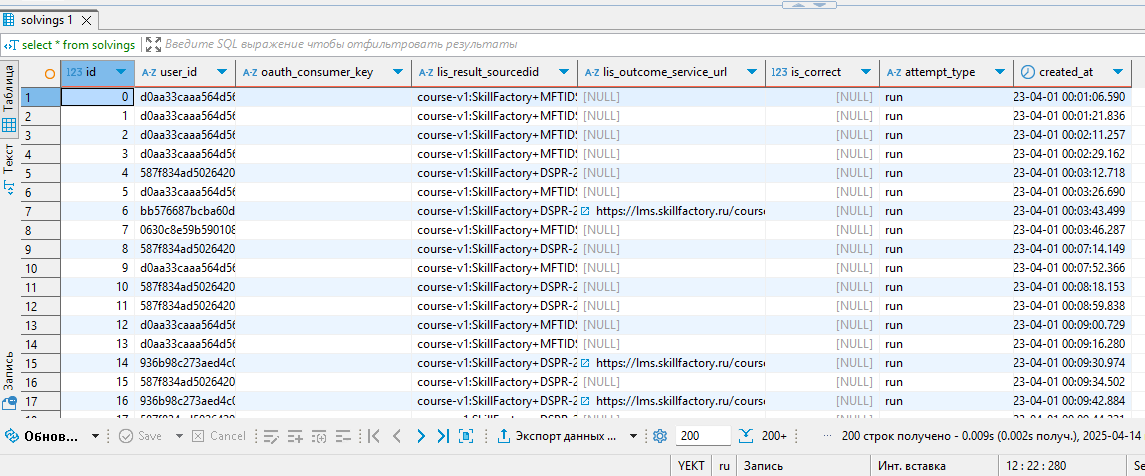

### Гугл-таблица статистики за день

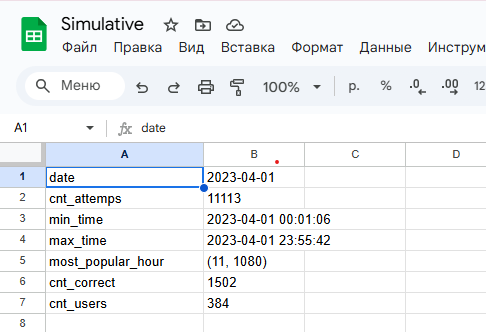

### Письмо

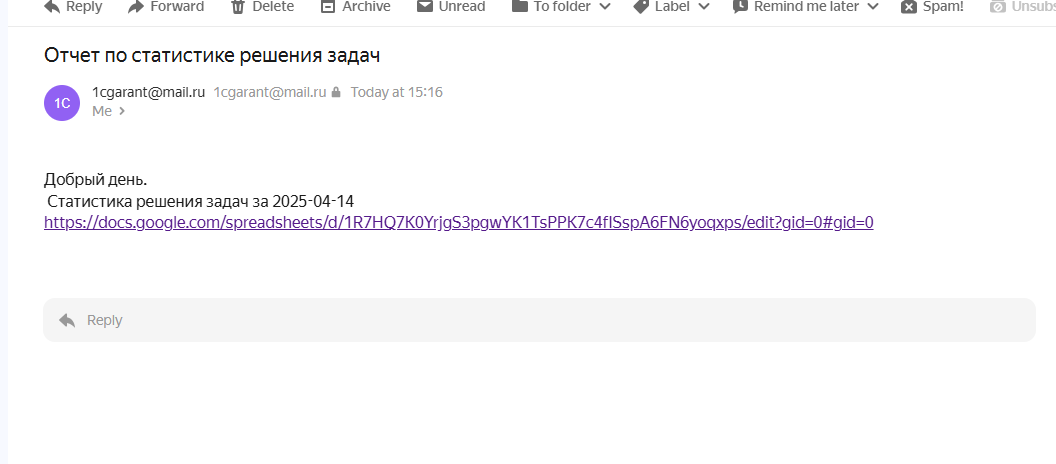

## Развитие проекта

Как можно развить проект.

1.   Доработать скрипт - загружать с API LIS текущие данные, а не исторические.
2.   После автоматизации скрипта улучшить безопасность - модуль Password с ключами вынести в отдельную папку приложения.
3.   Также в ходе автоматизации преобразовать архитектуру - иницииация экземпляров должна происходить отдельно от генерации данных. Кроме того, после автоматизации необходимо чуть поправить скрипт, исходя из условия дозаполения уже существующей таблицы PostgreSQL (сейчас начальное значение перичного ключа задается в лоб). Такая доработка необходима для избежания ошибки уникальности первичного ключа.
4. В ежедневный отчет добавить лист со статистиками решения задач каждый час.




